In [71]:
from glob import glob
import tempfile
import os

import pyopia.exampledata as testdata
import pyopia.io
import pyopia.classify
from pyopia.pipeline import Pipeline
import pyopia.process
import pyopia.statistics
import pyopia.background  # noqa: F401
import xarray
import pandas as pd
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import pyopia.instrument.silcam

In [72]:
database_path = '/Users/emlynd/Downloads/pysilcam-testdata/unittest-data/silcam_classification_database'
model_path = '/Users/emlynd/Downloads/pysilcam-testdata/keras_model/keras_model.h5'
cl = pyopia.classify.Classify(model_path=model_path)

In [73]:
def get_good_roi(category):
    '''
    calculate the percentage positive matches for a given category
    '''

    # list the files in this category of the training data
    files = glob(os.path.join(database_path, category, '*.tiff'))

    # loop through the database images
    for file in files:
        img = skimage.io.imread(file)  # load ROI
        prediction = cl.proc_predict(img)  # run prediction from silcam_classify

        ind = np.argmax(prediction)  # find the highest score

        # check if the highest score matches the correct category
        if cl.class_labels[ind] == category:
            return img, category

In [74]:
canvas = np.ones((2048, 2448, 3), np.float64) * 1

rc_shift = int(2048/len(cl.class_labels)/1.5)
rc = rc_shift

classes = glob(os.path.join(database_path, '*'))
print(classes)

categories = []

for cat in classes:
    name = os.path.split(cat)[-1]
    img, category = get_good_roi(name)
    categories.append(category)
    img_shape = np.shape(img)
    rc += rc_shift
    canvas[rc:rc + img_shape[0], rc: rc + img_shape[1], :] = np.float64(img)/255

settings = {'general': {'raw_files': None,
                        'pixel_size': 24},
            'steps': {'note': 'non-standard pipeline.'}
           }

# Initialise the pipeline class without running anything
MyPipeline = pyopia.pipeline.Pipeline(settings=settings, initial_steps='')

# Get the example trained model
model_path = pyopia.exampledata.get_example_model(os.getcwd())

# Add the classifier step description to settings (i.e. metadata)
MyPipeline.settings['steps'].update({'classifier':
                                       {'pipeline_class': 'pyopia.classify.Classify',
                                       'model_path': model_path}
                                    })

# Execute the classifier step we defined above
MyPipeline.run_step('classifier')
# This is the same as running:
# MyPipeline.data['cl'] = pyopia.classify.Classify(model_path=model_path)
# Note: the classifier step is special in that it's output is specifically data['cl'], rather than other new keys in data

MyPipeline.data['imraw'] = canvas
MyPipeline.data['timestamp'] = pd.Timestamp.now()

# Add the imageprep step description
MyPipeline.settings['steps'].update({'imageprep':
                                       {'pipeline_class': 'pyopia.instrument.silcam.ImagePrep',
                                        'image_level': 'imraw'}
                                    })
# Run the step
MyPipeline.run_step('imageprep')
# This is the same as running:
# ImagePrep = pyopia.instrument.silcam.ImagePrep(image_level='imraw')
# MyPipeline.data = ImagePrep(MyPipeline.data)

# Add the segmentation step description
MyPipeline.settings['steps'].update({'segmentation':
                            {'pipeline_class': 'pyopia.process.Segment',
                            'threshold': 1}}
                        )
# Run the step
MyPipeline.run_step('segmentation')
# This is the same as running:
# Segment = pyopia.process.Segment(threshold=settings['steps']['segmentation']['threshold'])
# data = Segment(data)

# Add the segmentation step description
MyPipeline.settings['steps'].update({'statextract':
                                        {'pipeline_class': 'pyopia.process.CalculateStats'}}
                                    )

# Run the step
MyPipeline.run_step('statextract')
# This is the same as running:
# CalculateStats = pyopia.process.CalculateStats()
# data = CalculateStats(data)

stats = pyopia.statistics.add_best_guesses_to_stats(MyPipeline.data['stats'])

out = [x[12:] for x in stats['best guess'].values]

['/Users/emlynd/Downloads/pysilcam-testdata/unittest-data/silcam_classification_database/copepod', '/Users/emlynd/Downloads/pysilcam-testdata/unittest-data/silcam_classification_database/faecal_pellets', '/Users/emlynd/Downloads/pysilcam-testdata/unittest-data/silcam_classification_database/other', '/Users/emlynd/Downloads/pysilcam-testdata/unittest-data/silcam_classification_database/bubble', '/Users/emlynd/Downloads/pysilcam-testdata/unittest-data/silcam_classification_database/diatom_chain', '/Users/emlynd/Downloads/pysilcam-testdata/unittest-data/silcam_classification_database/oil', '/Users/emlynd/Downloads/pysilcam-testdata/unittest-data/silcam_classification_database/oily_gas']
Initialising pipeline
Classify  ready with: {'model_path': 'keras_model.h5'}  and data dict_keys(['cl', 'settings', 'raw_files'])
ImagePrep  ready with: {'image_level': 'imraw'}  and data dict_keys(['cl', 'settings', 'raw_files', 'imraw', 'timestamp'])
Segment  ready with: {'threshold': 1}  and data dict_k

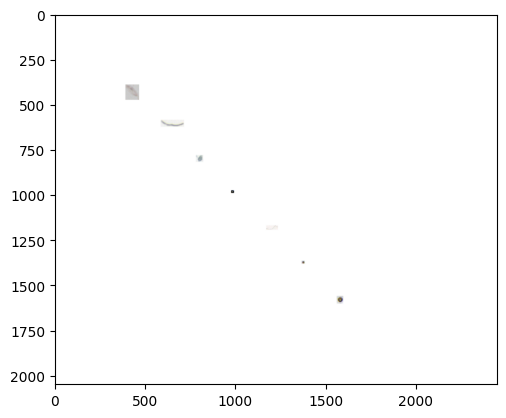

In [75]:
plt.imshow(MyPipeline.data['imref'])

In [76]:
print(categories)
print(out)

['copepod', 'faecal_pellets', 'other', 'bubble', 'diatom_chain', 'oil', 'oily_gas']
['copepod', 'faecal_pellets', 'other', 'bubble', 'diatom_chain', 'oil', 'oily_gas']


In [77]:
assert categories == out, 'Classes returned from classifier do not match what was given to the pipeline'